# sentence reconstruction from srt file

In [286]:
import numpy as np
import pandas as pd
import re

In [287]:
#path = "C:/Users/NA/Saved Games/eeg_study/modified_500_days_of_summer_subtitle.srt"
path = "C:/Users/NA/Saved Games/eeg_study/subtitle_all/pulp_fiction_subtitle.srt"
#path = "C:/Users/NA/Saved Games/eeg_study/subtitle_all/the_usual_suspects_subtitle.srt"
with open(path, "r", encoding='utf-8-sig') as f:
    string = f.read()
    lines = string.split("\n")
    time_arr = []
    subtitles = []
    first_text = True
    continueable = False
    for line in lines:
        if (len(line) < 5 and line.isdigit()) or len(line) == 0:
            continue
            
        if " --> " not in line:
            text = line.strip()
            if continueable : # add subtitle with ... place holder of differnt time annotation
                last_subtitles = subtitles[-1]
                subtitles.pop()
                subtitles.append((last_subtitles + " " + text))

                last_time = time_arr[-2]
                time_arr.pop()
                time_arr.pop()
                time_arr.append((last_time[0], end_time))
                continueable = False
                first_text = False 

            else:
                if "..." in line and not first_text:
                    text = text.replace("...", "")
                    continueable = True
                elif "..." in line and first_text: # add this to skip the continuable if ""..." presence only in the line
                    text = text.replace("...", "")
                    
                if first_text  :
                    subtitles.append(text)
                    first_text = False
                else: # add subtitle between line of the same time annotation
                    last_subtitles = subtitles[-1]
                    subtitles.pop()
                    subtitles.append((last_subtitles + " " + text))

            # to clean data with only time/subtitle
            if len(subtitles) != len(time_arr):
                print(text) 
                print(start_time)
                print(f"len subtitle is {len(subtitles)}")
                print(f"len time ios {len(time_arr)}")

        else:
            first_text = True
            time = line.split(" --> ")
            start = time[0].split(",")[0].split(":")
            end = time[1].split(",")[0].split(":")
            start_ms = time[0].split(",")[1]
            end_ms = time[1].split(",")[1]
            start_time = int(start[0]) * 3600 + int(start[1]) * 60 + float(start[2]) + float(start_ms) / 1000
            end_time = int(end[0]) * 3600 + int(end[1]) * 60 + float(end[2]) + float(end_ms) / 1000
            time_arr.append((start_time, end_time))
    

In [288]:
sentence_arr = pd.DataFrame({
    "start_time": [t[0] for t in time_arr],
    "end_time": [t[1] for t in time_arr],
    "text": subtitles
})

In [289]:
sentence_arr

,start_time,end_time,text
0,27.40,30.711,Forget it. It's too risky. I'm through doing t...
1,30.80,34.077,You always say that. The same thing every time.
2,34.20,35.998,"""I'm through, never again, too dangerous."""
3,36.12,38.475,I know that's what I always say. I'm always ri...
4,38.56,41.791,- You forget about it in a day or two. - The d...
...,...,...,...
1947,8541.08,8543.879,I'm trying real hard
1948,8543.96,8546.110,to be the shepherd.
1949,8560.84,8562.638,Go.
1950,8579.64,8581.950,I think we should be leaving now.


In [290]:
def clean_sentence(sentence):
    sentence = re.sub(r'\W+', ' ', sentence)  # Remove symbols/punctuation
    sentence = sentence.lower()               # Lowercase
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove extra spaces
    return sentence.strip()  
sentence_arr['text'] = sentence_arr['text'].apply(clean_sentence)

In [291]:
sentence_arr

,start_time,end_time,text
0,27.40,30.711,forget it it s too risky i m through doing tha...
1,30.80,34.077,you always say that the same thing every time
2,34.20,35.998,i m through never again too dangerous
3,36.12,38.475,i know that s what i always say i m always rig...
4,38.56,41.791,you forget about it in a day or two the days o...
...,...,...,...
1947,8541.08,8543.879,i m trying real hard
1948,8543.96,8546.110,to be the shepherd
1949,8560.84,8562.638,go
1950,8579.64,8581.950,i think we should be leaving now


# Label text with RoBERTa transformer

## sentiment analysis

### RoBERTA

In [292]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AutoModel
from scipy.special import softmax

#load model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model_sentiment = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [293]:
#apply model output probability for each sentiment
all_scores = []
input_vector = []
for sentence in sentence_arr['text']:
    encoded_input = tokenizer(sentence, return_tensors='pt')
    output = model_sentiment(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    all_scores.append(scores)

In [294]:
# select the most dominat probability and make new column for class
score_roberta = pd.DataFrame(all_scores, columns=['negative', 'neutral', 'positive'])
score_roberta['label'] = score_roberta.apply(lambda x: x.idxmax(), axis=1)
score_roberta['label'] = score_roberta['label'].map({'neutral': 0, 'negative': -1, 'positive': 1})
#score_roberta['label'].to_csv("score_roberta.csv")

### Vader

In [295]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = []
for sentence in sentence_arr['text']:
    vs = analyzer.polarity_scores(sentence)
    sentiment.append(vs)

In [296]:
score_vader = pd.DataFrame(sentiment)
score_vader['label'] = score_vader['compound'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))
#score_vader['label'].to_csv("score_vader.csv")
# 0 neutral, 1 negative, 2 positive

### textblob

In [297]:
from textblob import TextBlob
sentiment_tb = []
for sentence in sentence_arr['text']:
    object_ = TextBlob(sentence)
    sentiment_tb.append(object_.sentiment.polarity)
sentiment_tb = pd.Series(sentiment_tb)

In [298]:
score_textblob = sentiment_tb.apply(lambda x: 1 if x >= 0.15 else (-1 if x <= -0.15 else 0))
#score_textblob.to_csv("score_textblob.csv")

### export data

In [299]:
score_all = pd.DataFrame(score_textblob, columns= ['TextBlob'])
score_all['vader'] = score_vader['label']
score_all['roberta'] = score_roberta['label']
score_all.insert(0, 'sentence', sentence_arr['text'])
score_all.insert(0, 'start_time', sentence_arr['start_time'])
score_all.insert(1, 'end_time', sentence_arr['end_time'])
score_all


,start_time,end_time,sentence,TextBlob,vader,roberta
0,27.40,30.711,forget it it s too risky i m through doing tha...,-1,-1,-1
1,30.80,34.077,you always say that the same thing every time,0,0,-1
2,34.20,35.998,i m through never again too dangerous,-1,1,-1
3,36.12,38.475,i know that s what i always say i m always rig...,1,0,1
4,38.56,41.791,you forget about it in a day or two the days o...,0,-1,-1
...,...,...,...,...,...,...
1947,8541.08,8543.879,i m trying real hard,-1,-1,0
1948,8543.96,8546.110,to be the shepherd,0,0,0
1949,8560.84,8562.638,go,0,0,0
1950,8579.64,8581.950,i think we should be leaving now,0,0,-1


In [300]:
tb = score_all['TextBlob'].value_counts()
roberta = score_all['roberta'].value_counts()
vader = score_all['vader'].value_counts()

# Step 2: Combine into a DataFrame
# This handles missing categories automatically
counts_df = pd.concat([tb, roberta, vader], axis=1, keys=['TextBlob', 'roberta', 'vader'])

In [301]:
counts_df

,TextBlob,roberta,vader
0,1217,1047,867
-1,373,653,527
1,362,252,558


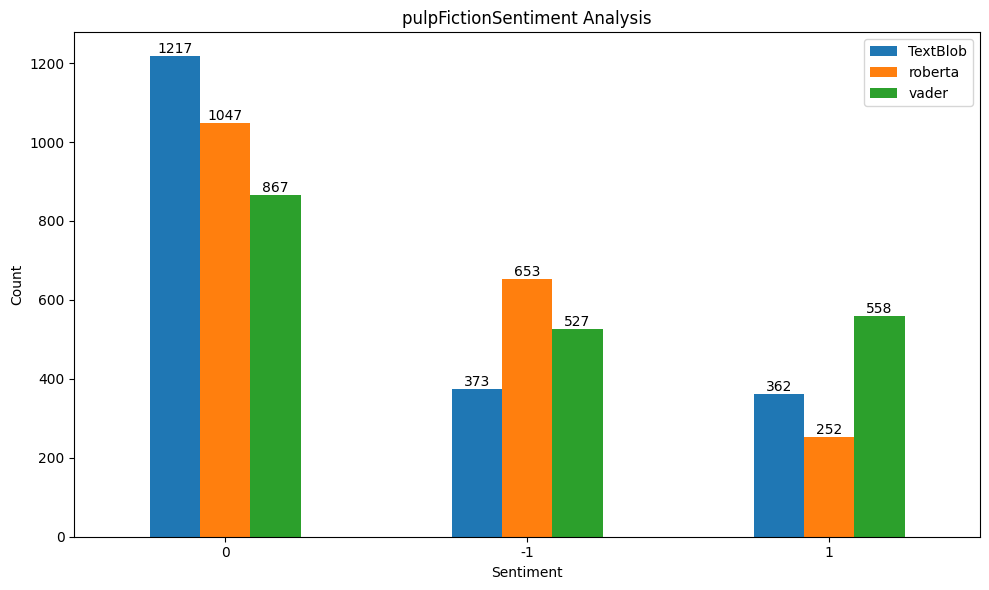

In [302]:
import matplotlib.pyplot as plt
import os

out_name= "pulpFiction"
out_path = "./image_output/"
csv_path = './csv_output/'
# Create plot
ax = counts_df.plot(kind='bar', 
                   figsize=(10, 6),
                   rot=0)  # Keep sentiment labels horizontal

# Add labels and title
plt.title( out_name + 'Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.tight_layout()
plt.savefig(os.path.join(out_path,out_name)+ '.jpg')
plt.show()

score_all.to_csv(os.path.join(csv_path,out_name)+ '.csv')

### Sentence transformer mpnet

In [ ]:
X = embedding_mpnet
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7112

=== Training: SVM (linear) ===
Validation Accuracy: 0.7059

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6898


In [ ]:
X = embedding_mpnet
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7166

=== Training: SVM (linear) ===
Validation Accuracy: 0.7005

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6471


In [ ]:
X = embedding_mpnet
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7380

=== Training: SVM (linear) ===
Validation Accuracy: 0.7594

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7112


In [150]:
score_all.to_csv('ShawShankRedemption_class_of_sentence.csv')

### similarity score

In [148]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(score_vader['label'].values, score_roberta['label'].values)
sim = sum(x == y for x, y in zip(score_vader['label'], score_roberta['label'] )) / len(score_vader['label'])
score = jaccard_score(score_vader['label'].values, score_roberta['label'].values, average='weighted')

accuracy_tb_v = accuracy_score(score_vader['label'].values, score_textblob)
sim_tb_v = sum(x == y for x, y in zip(score_vader['label'], score_textblob )) / len(score_vader['label'])
score_tb_v = jaccard_score(score_vader['label'].values, score_textblob, average='weighted')

accuracy_tb_r = accuracy_score(score_textblob, score_roberta['label'].values)
sim_tb_r = sum(x == y for x, y in zip(score_textblob, score_roberta['label'] )) / len(score_roberta['label'])
score_tb_r = jaccard_score(score_textblob.values, score_roberta['label'].values, average='weighted')

In [33]:
print(f"similarity score vader roberta is {sim}")
print(f"jaccard score vader roberta is {score}")
print(f"accuracy score vader roberta is {accuracy}")

similarity score vader roberta is 0.6168674698795181
jaccard score vader roberta is 0.439582572855067
accuracy score vader roberta is 0.6168674698795181


In [151]:
print(f"similarity score vader textblob is {accuracy_tb_v}")
print(f"jaccard score vader textblob is {score_tb_v}")
print(f"accuracy score vader textblob is {sim_tb_v}")

similarity score vader textblob is 0.6404028436018957
jaccard score vader textblob is 0.45481739143295324
accuracy score vader textblob is 0.6404028436018957


In [152]:
print(f"similarity score textblob roberta is {accuracy_tb_r}")
print(f"jaccard score textblob roberta is {sim_tb_r}")
print(f"accuracy score textblob roberta is {score_tb_r}")

similarity score textblob roberta is 0.6433649289099526
jaccard score textblob roberta is 0.6433649289099526
accuracy score textblob roberta is 0.5159642440229745


## emotion analysis

# Change word to vector 

## sentence / word tokenization and embeddingh

### word2vec embedding

In [50]:
# word2vec
def sentence_to_vec(sentence, model, vector_size=300):
    words = sentence.lower().split()  
    #tokens = [re.sub(r'\W+', '', token) for token in words] 
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# load model to embed the word into vector
from gensim.models import Word2Vec
from gensim.downloader import load
model_w2v = load("word2vec-google-news-300")

In [51]:
# check word in dict
tokens = ['this', 'is', 'a', 'story', 'of', 'boy', 'meets', 'girl']
tokens2 = ['the', 'boy', 'tom', 'hansen', 'of', 'margate', 'new', 'jersey', 'grew', 'up', 'believing', 'that', 'hed',
            'never', 'truly', 'be', 'happy', 'until', 'the', 'day', 'he', 'met', 'the', 'one']
valid_tokens = [token for token in tokens if token in model_w2v]
print("Tokens in model:", valid_tokens)

valid_tokens2 = [token for token in tokens2 if token in model_w2v]
print("Tokens 2 in model:", valid_tokens2)

Tokens in model: ['this', 'is', 'story', 'boy', 'meets', 'girl']
Tokens 2 in model: ['the', 'boy', 'tom', 'hansen', 'new', 'jersey', 'grew', 'up', 'believing', 'that', 'hed', 'never', 'truly', 'be', 'happy', 'until', 'the', 'day', 'he', 'met', 'the', 'one']


### distolbert-tokenization and embedding

In [ ]:
import torch
import tqdm
def get_cls_embeddings_from_series(text_series, tokenizer,model, max_length=128, batch_size=1):
    """
    Converts a Pandas Series of text into a NumPy array of CLS embeddings using DistilBERT.
    where CLS is used in the model as a sentence embedding. 

    Parameters:
        text_series (pd.Series): Series of text strings
        max_length (int): Maximum token length per sentence
        batch_size (int): Batch size for processing (optional, useful for large sets)

    Returns:
        np.ndarray: Array of shape (n_samples, 768) containing CLS embeddings
    """
    cls_embeddings = []

    for text in text_series:
        encoded_input = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=max_length
        )

        with torch.no_grad():
            output = model(**encoded_input)

        cls_vec = output.last_hidden_state[:, 0, :]  # [1, 768]
        #cls_embeddings.append(cls_vec.squeeze(0).numpy())  # [768]
        cls_embeddings.append(np.expand_dims(cls_vec.squeeze(0).numpy(), axis=0))

    return np.vstack(cls_embeddings) # shape: [num_sentences, 768]

### sentiment_tokenization from roberta model

In [53]:
# sentiment_tokenization
model_cardiff = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer_ = AutoTokenizer.from_pretrained(model_cardiff)

def car_diff_embed(text_series, max_length=128, batch_size=1):

    car_diff = []
    for text in text_series:

        embedding_cardiff = tokenizer_(
            text,
            return_tensors='pt',       # Return PyTorch tensors
            padding='max_length',      # Pad all to the same max_length
            truncation=True,           # Truncate if over max_length
            max_length=162      
        )

        car_diff.append(embedding_cardiff['input_ids'].numpy())

    return car_diff 

In [86]:
features

array([[ 0.6997454 ,  0.15458025, -0.01059891, ...,  0.47170144,
         0.93815315, -0.41023418],
       [-0.54252654,  0.6246307 ,  0.03168805, ..., -0.15648341,
        -0.71036536, -0.00857123]], dtype=float32)

### run embedding and tokenization function

In [ ]:
# distilbert fine-tuned with standford dataset for sentiment analysis SST2
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer_BERT = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_BERT = DistilBertModel.from_pretrained("distilbert-base-uncased")
model_BERT.eval()

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer_sentence_finetuned = AutoTokenizer.from_pretrained(model_name)
model_sentence_finetuned = AutoModel.from_pretrained(model_name)  
model_sentence_finetuned.eval()



sentence_arr['embedding_w2v'] = sentence_arr['text'].apply(lambda x: np.array(sentence_to_vec(x, model_w2v)))
embedding_tfm = get_cls_embeddings_from_series(sentence_arr['text'], tokenizer= tokenizer_BERT, model= model_BERT)
embedding_sst = get_cls_embeddings_from_series(sentence_arr['text'], tokenizer= tokenizer_sentence_finetuned, model= model_sentence_finetuned)

embedding_cardiff = np.squeeze(np.array(car_diff_embed(sentence_arr['text'])))

sentence_arr['vader'] = score_vader['label']
sentence_arr['roberta'] = score_roberta['label']
sentence_arr['textB'] = score_textblob

In [77]:
from sentence_transformers import SentenceTransformer
model_miniLM = SentenceTransformer("all-MiniLM-L6-v2")
model_mpnet = SentenceTransformer("all-mpnet-base-v2")
embedding_miniLM = model_miniLM.encode(sentence_arr['text'].values)
embedding_mpnet = model_mpnet.encode(sentence_arr['text'].values)

c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NA\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to r

## classification sentiment with word vector as a feature

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

### word2vec

In [64]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7059

=== Training: SVM (linear) ===
Validation Accuracy: 0.7914

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7380


In [65]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.6310

=== Training: SVM (linear) ===
Validation Accuracy: 0.6684

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6578


In [66]:
X = np.vstack(sentence_arr['embedding_w2v'].values)
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 300) | Val size: (187, 300) | Test size: (187, 300)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7968

=== Training: SVM (linear) ===
Validation Accuracy: 0.8021

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7647


### distilbert embedding

In [67]:

X = embedding_tfm
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.5294

=== Training: SVM (linear) ===
Validation Accuracy: 0.4920

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.5401


In [68]:
X = embedding_cardiff
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 162) | Val size: (187, 162) | Test size: (187, 162)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.5508

=== Training: SVM (linear) ===
Validation Accuracy: 0.5775

=== Training: XGBoost ===
Validation Accuracy: 0.5455


In [69]:
X = embedding_cardiff
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 162) | Val size: (187, 162) | Test size: (187, 162)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6364

=== Training: SVM (linear) ===
Validation Accuracy: 0.6310

=== Training: XGBoost ===
Validation Accuracy: 0.6524


### sentence embedding

In [ ]:
X = embedding_miniLM
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.6952

=== Training: SVM (linear) ===
Validation Accuracy: 0.6738

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6684


In [ ]:
X = embedding_miniLM
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7273

=== Training: SVM (linear) ===
Validation Accuracy: 0.7166

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7219


In [ ]:
X = embedding_miniLM
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 384) | Val size: (187, 384) | Test size: (187, 384)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7487

=== Training: SVM (linear) ===
Validation Accuracy: 0.7701

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7380


### Sentence transformer mpnet

In [78]:
X = embedding_mpnet
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7112

=== Training: SVM (linear) ===
Validation Accuracy: 0.7059

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6898


In [79]:
X = embedding_mpnet
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7166

=== Training: SVM (linear) ===
Validation Accuracy: 0.7005

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.6471


In [ ]:
X = embedding_mpnet
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7380

=== Training: SVM (linear) ===
Validation Accuracy: 0.7594

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7112


### Sentence transformer fine-tunedsst
currently perform the best for all

In [90]:
X = embedding_sst
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7594

=== Training: SVM (linear) ===
Validation Accuracy: 0.7273

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7594


In [91]:
X = embedding_sst
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7166

=== Training: SVM (linear) ===
Validation Accuracy: 0.7112

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7273


In [92]:
X = embedding_sst
y = sentence_arr['textB']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 768) | Val size: (187, 768) | Test size: (187, 768)
textB
0    786
2    353
1    106
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.7594

=== Training: SVM (linear) ===
Validation Accuracy: 0.7059

=== Training: XGBoost ===


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:20:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7487


### use the sentiment score

In [386]:
X = score_roberta.iloc[:,:-1]
y = sentence_arr['roberta']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 3) | Val size: (187, 3) | Test size: (187, 3)
roberta
0    721
2    270
1    254
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.9893

=== Training: SVM (linear) ===
Validation Accuracy: 0.9786

=== Training: XGBoost ===
Validation Accuracy: 0.9786


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:17:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [405]:
np.expand_dims(score_vader.iloc[:,3],axis = 1).shape

(1245, 1)

In [406]:
X = np.expand_dims(score_vader.iloc[:,3],axis = 1)
y = sentence_arr['vader']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Train size:", X_train.shape, "| Val size:", X_val.shape, "| Test size:", X_test.shape)
print(y.value_counts())

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "SVM (linear)": SVC(kernel='rbf', C=1.0, probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=4, learning_rate=0.1)
}

# === Train and evaluate each model ===
for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    #print("Classification Report:")
    #print(classification_report(y_val, y_val_pred))

Train size: (871, 1) | Val size: (187, 1) | Test size: (187, 1)
vader
0    527
2    514
1    204
Name: count, dtype: int64

=== Training: Logistic Regression ===
Validation Accuracy: 0.9572

=== Training: SVM (linear) ===
Validation Accuracy: 0.9947

=== Training: XGBoost ===
Validation Accuracy: 1.0000


c:\Users\NA\.conda\envs\eeg_study\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:22:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
